# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Nicola Visentin"
STUDENT_1_STUDENT_NUMBER = "6354815"
STUDENT_1_NETID = "nvisentin"
STUDENT_1_EMAIL = "N.Visentin@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 3g - Behavioural Cloning of a reference trajectory (8.5p)
**Authors:** Giovanni Franzese, Lorenzo Lyons (L.Lyons@tudelft.nl)

In this part of the task, we imagine to have a dataset that is coming from a robot that is executing a certain behaviour and the only thing that we can obseve is 
- the reference trajectory

We are going to use a GP to model the desired delta angles as a function of the angles and then we are going to use the GP to predict them during control, converting the delta in torque using a proportional controller. This is usually refereed to as **Behavioural Cloning**. 

In [3]:
# import all Python modules
from distutils.util import strtobool
from functools import partial
import gpytorch
from gpytorch.models import ApproximateGP
from IPython.display import display, HTML  # For animations in the notebook
import jax

jax.config.update("jax_platforms", "cpu")  # set default device to 'cpu'
jax.config.update("jax_enable_x64", True)  # double precision
from jax import Array
from jax import numpy as jnp
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import os
import sys
import torch
from torch.autograd.functional import jacobian
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

from jax_double_pendulum.analysis import *
from jax_double_pendulum.dynamics import dynamical_matrices
from jax_double_pendulum.motion_planning import (
    generate_ellipse_trajectory,
    ELLIPSE_PARAMS,
)
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.utils import normalize_link_angles
from jax_double_pendulum.visualization import animate_robot

# define boolean to check if the notebook is run for autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

### Generate the reference trajectory

In [4]:
# simulation parameters
sim_duration = 15.0  # [s]
sim_dt = 1e-2  # [s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate reference trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

### Generate the dataset by extracting the angle and delta angle

In [5]:
reference_angle = np.array(traj_ts["th_ts"])
step_ahead = 1
reference_angle[:, 1] = (
    reference_angle[:, 1] - reference_angle[:, 0]
)  # we prefer to control the second link angle by considering the relative angle with respect to the first link
reference_angle_delta = (
    reference_angle[step_ahead:, :] - reference_angle[:-step_ahead, :]
)
reference_angle[:, 0] = np.angle(np.exp(1j * reference_angle[:, 0]))
reference_angle[:, 1] = np.angle(np.exp(1j * reference_angle[:, 1]))
reference_angle = reference_angle[:-step_ahead, :]

### Eximine the dataset by priting the angles and the delta angles

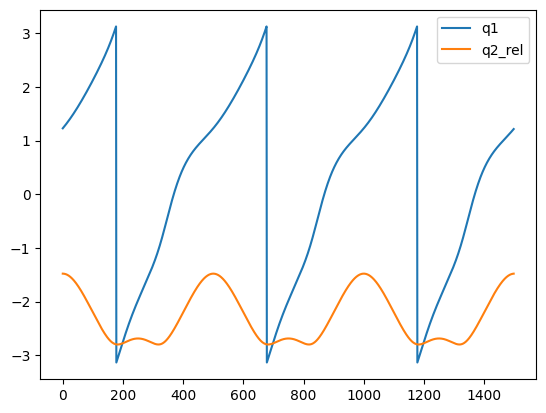

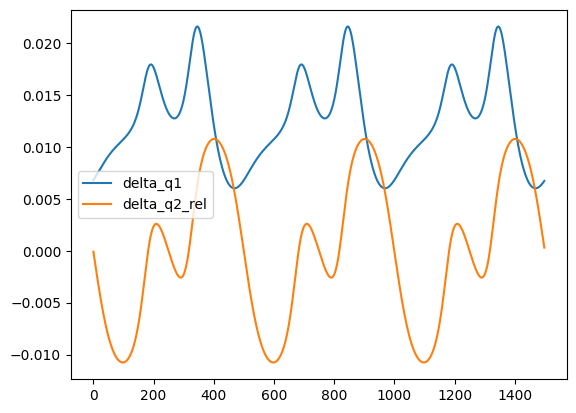

In [6]:
plt.figure()
plt.plot(reference_angle[:, 0])
plt.plot(reference_angle[:, 1])
plt.legend(["q1", "q2_rel"])

plt.figure()
plt.plot(reference_angle_delta[:, 0])
plt.plot(reference_angle_delta[:, 1])
plt.legend(["delta_q1", "delta_q2_rel"])

### Create dataset

In [7]:
X = reference_angle
Y = reference_angle_delta
X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

### 3g-1 DEFINE A KERNEL FUNCTION THAT IS PERIODIC WITH A PERIOD OF 2 PI. (1p)
Since we work with angles, we know that the angles are periodic with a period of 2 pi. Using the right kernel function will help the Gaussian Process (GP) to model the data.
Don't forget to add the scale kernel in the front of the periodic kernel and to have it to be batch independent like in the previous notebooks. 

**Cheat sheet:**

How to define a periodic kernel that is periodic with a period of 2pi:
``` python 
PeriodicKernel(period_length_constraint=gpytorch.constraints.Interval(lower_bound=torch.tensor([2* torch.pi-0.01]), upper_bound=torch.tensor([2* torch.pi+0.01]), initial_value=torch.tensor([2* torch.pi]))) 
```

How to print the hyperparameters of a periodic kernel:
``` python
gp.covar_module.base_kernel.period_length
```

In [8]:
class MultitaskGPModel(ApproximateGP):
    def __init__(self, num_tasks, inducing_points, constant_mean=False):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_tasks])
        )

        variational_strategy = (
            gpytorch.variational.IndependentMultitaskVariationalStrategy(
                gpytorch.variational.VariationalStrategy(
                    self,
                    inducing_points,
                    variational_distribution,
                    learn_inducing_locations=True,
                ),
                num_tasks=num_tasks,
                task_dim=-1,
            )
        )

        super().__init__(variational_strategy)

        if constant_mean:
            self.mean_module = gpytorch.means.ConstantMean(
                batch_shape=torch.Size([num_tasks])
            )
        else:
            self.mean_module = gpytorch.means.ZeroMean(
                batch_shape=torch.Size([num_tasks])
            )

        # self.covar_module = gpytorch.kernels.ScaleKernel(, batch_shape=torch.Size([num_tasks]))
        period_length_constraint=gpytorch.constraints.Interval(
            lower_bound=torch.tensor([2* torch.pi-0.01]), 
            upper_bound=torch.tensor([2* torch.pi+0.01]), 
            initial_value=torch.tensor([2* torch.pi]),
        )
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PeriodicKernel(period_length_constraint=period_length_constraint),
            batch_shape=torch.Size([num_tasks]),
        )   

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### 3g-2 Define the gp and the likelihood inside the model (1p)

In [9]:
class Model:
    def __init__(self, X, Y, n_ind=100, batch_size=256):
        self.X = X
        self.Y = Y
        # number of inducing points
        unique_random_indices = torch.randperm(len(X))[:n_ind]
        inducing_points = X[unique_random_indices]
        self.inducing_points = inducing_points
        self.batch_size = batch_size
        self.is_cuda = False
        self.rmse_loss_vec = np.array([])

        self.gp = MultitaskGPModel(num_tasks=Y.shape[1], inducing_points=inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Y.shape[1])

    def to_cuda(self):
        if torch.cuda.is_available():
            self.gp = self.gp.cuda()
            self.likelihood = self.likelihood.cuda()
            self.X = self.X.cuda()
            self.Y = self.Y.cuda()
            self.is_cuda = True
        else:
            print("Cuda not available")

    def predict(self, x):
        if self.is_cuda:
            x = x.cuda()
        return self.likelihood(self.gp(x))

    def variance_fun(self, x):
        predictions = self.gp(x)
        return predictions.variance[0, :]

    def derivative_variance(self, x):
        if self.is_cuda:
            x = x.cuda()
        jac = jacobian(self.variance_fun, x).detach()
        jac = jac.reshape(-1, x.size(1))
        return torch.diag(jac)

    def train(self, num_epochs=400):
        self.gp = self.gp.double()
        self.likelihood = self.likelihood.double()
        self.X = self.X.double()
        self.Y = self.Y.double()
        self.train_dataset = TensorDataset(self.X, self.Y)
        self.train_loader = DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
        self.gp.train()
        self.likelihood.train()

        optimizer = torch.optim.Adam(
            [
                {"params": self.gp.parameters()},
                {"params": self.likelihood.parameters()},
            ],
            lr=0.01,
        )

        # Our loss object. We're using the VariationalELBO
        self.mll = gpytorch.mlls.VariationalELBO(
            self.likelihood, self.gp, num_data=self.Y.size(0)
        )

        # to plot the loss function
        self.rmse_loss_vec = np.zeros(num_epochs)

        for i in tqdm(range(num_epochs)):
            # Within each iteration, we will go over each minibatch of data
            loss_sum = 0.0
            for x_batch, y_batch in self.train_loader:
                optimizer.zero_grad()
                output = self.gp(x_batch)
                loss = -self.mll(output, y_batch)
                loss.backward()
                optimizer.step()
                loss_sum += loss.detach().cpu()
            self.rmse_loss_vec[i] = (
                torch.sqrt(loss_sum / len(self.train_loader)).detach().item()
            )

    def plot_convergence(self, experiment_name: str):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.rmse_loss_vec, label="loss")
        ax.set_xlabel("Epochs")
        ax.set_ylabel(r"Trainings RMSE for $\hat{\ddot{\theta}}$ [rad/s^2]")
        plt.savefig(
            str(outputs_dir / f"task_3g_training_convergence_{experiment_name}.pdf")
        )

### 3g-3 Define the model and train it (0.5p)

In [10]:
torch.manual_seed(42)

controller_model = Model(X,Y)
#controller_model.to_cuda()
controller_model.train()

  0%|          | 0/400 [00:00<?, ?it/s]

## 3g-4 Let's use the model to control the robot (1p)
In the next cell you have use the mean preiction of the output of the GP to control the robot. You also have to tune the proportional gain for the proportional controller. 

In [11]:
# run closed-loop simulation with GP-based controller
sim_dt = 0.01
sim_duration = 12.0

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate reference trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# set the initial state to the start of the reference trajectory
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]

# import the feedforward gravity compensation controller from problem_2/controllers.ipynb
sys.path.insert(0, Path.cwd().parent / "problem_2")
from ipynb.fs.full.controllers import ctrl_ff_gravity_compensation

# define feedforward gravity compensation controller (as it is asked in the pdf of the assignment)
ctrl_ff = partial(
    ctrl_ff_gravity_compensation, partial(dynamical_matrices, ROBOT_PARAMS)
)

# define the feedback function that implements the GP-based controller
def ctrl_fb(th: Array, th_d: Array, th_des: Array, th_d_des: Array) -> Array:
    """
    GP-based feedback controller.
    Args:
        th: link angles. Shape: (2,)
        th_d: link velocities. Shape: (2,)
        th_des: desired link angles. Shape: (2,)
        th_d_des: desired link velocities. Shape: (2,)
    Returns:
        tau_gp: link torques computed by the GP-based controller. Shape: (2,)
    """
    # compute the normalized joint angles (i.e., relative angles) from the link angles
    th_rel = normalize_link_angles(jnp.array([th[0], th[1] - th[0]]))

    # construct input for GP
    gp_input = torch.tensor(np.array(th_rel)).unsqueeze(0)

    with torch.no_grad():
        # evaluate GP output and extract the mean
        gp_output = controller_model.predict(gp_input)
        gp_mean = gp_output.mean.numpy().flatten()
        kp =  500 # proportional gain in range [200, 1000]
    
        dq = gp_mean
        Kp = kp * np.eye(2)  # [Nm/rad]
        tau_gp = Kp @ dq

    return tau_gp


# simulate the robot together in closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=ctrl_fb,
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir / f"task_3g_robot_animation_behavioural_cloning_delta.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

starting simulation
finished simulation
producing animation


### 3g-5 EXPLAIN WHY THE CONTROL WITH THE GP IS NOT GOOD ENOUGH (2p)

YOUR ANSWER HERE:

In [12]:
# This type of control is similar to the one we saw in Task 3f (behavioural cloning), with some differences. In the previous notebook, the 
# GP was trying to copy the response of a PD controller (in terms of generated control command) as function of the current configuration. 
# As we already said, this was not so effective since the GP was simply doing what the PD did in that specific situation, without having in
# reality any knowledge about the actual condition (error, speed, etc).
# Now the idea is to train the GP to predict the "distance" to the next configuration of the desired trajectory (in terms of delta angles), 
# as function of the current configuration. Then we use this information to generate the control torques, proportionally to this "distance" 
# (the higher the "step", the higher the torque).
# With this strategy, not only we don't have any information during control about the real condition of the robot (error, speed, ...), but 
# we are not even using the GP to directly produce the control action that should track the moving reference. Thus, we expect this 
# controller to be even worse than before.

## 3g-6 ADD A MINIMIZATION OF VARIANCE ON TOP OF THE PREVIOUS CONTROLLER (1p)
In order to increase the performance of the learned torque behaviour, we are going to add a delta to the prediction towards direction of maximum decrease of the predicted epistemic uncertainty, i.e. in the opposite direction of the gradient of the variance of the GP prediction. We also going to add some damping to the control law to avoid oscillations.

 You need to
 - make prediction of mean and standard deviation of the GP prediction
 - compute the gradient of the variance of the GP prediction with respect to the input (check the Model class to pick the right method, do not implement it yourself)
 - define the new delta in the negative direction of the gradient, proportional to the standard deviation of the GP prediction
 - tune the proportional and the derivative gain of the controller

In [13]:
# run closed-loop simulation with GP-based controller
sim_dt = 0.01
sim_duration = 12.0 

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# generate reference trajectory
traj_ts = generate_ellipse_trajectory(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    **ELLIPSE_PARAMS,
)

# set the initial state to the start of the reference trajectory
th_0 = traj_ts["th_ts"][0]
th_d_0 = traj_ts["th_d_ts"][0]


# define the feedback function that implements the GP-based controller
def ctrl_fb(th: Array, th_d: Array, th_des: Array, th_d_des: Array) -> Array:
    """
    GP-based feedback controller.
    Args:
        th: link angles. Shape: (2,)
        th_d: link velocities. Shape: (2,)
        th_des: desired link angles. Shape: (2,)
        th_d_des: desired link velocities. Shape: (2,)
    Returns:
        tau_gp: link torques computed by the GP-based controller. Shape: (2,)
    """
    # compute the normalized joint angles (i.e., relative angles) from the link angles
    th_rel = normalize_link_angles(jnp.array([th[0], th[1] - th[0]]))

    # construct input for GP
    gp_input = torch.tensor(np.array(th_rel)).unsqueeze(0)

    with torch.no_grad():
        # evaluate GP output
        gp_output = controller_model.predict(gp_input)
        gp_mean = gp_output.mean.T
        gp_var = gp_output.stddev.T
        
    gp_variance_gradient = controller_model.derivative_variance(gp_input).unsqueeze(1)
    delta_variance = - gp_var * torch.sign(gp_variance_gradient)
    kp =  500 # proportional gain in range [200, 1000]: 500
    kd =  3 # derivative gain in range [1,5]: 3
    k_var = 1 # variance minimization gain in range [0,2]: 1

    # move the delta attractor in the direction of minimum uncertainty
    dq = gp_mean + k_var * delta_variance
    dq = dq.numpy().flatten()

    Kp = kp * np.array([[1,0],[0,3]])  # [Nm/rad]
    Kd = kd * np.eye(2)  # [Nm s/rad]

    tau_gp = Kp @ dq + Kd @ (-th_d)
    
    return tau_gp


# simulate the robot together in closed loop with the GP-based controller
print("starting simulation")
sim_ts = simulate_robot(
    ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
    ctrl_ff=ctrl_ff,
    ctrl_fb=ctrl_fb,
    jit_compile=False,
)
print("finished simulation")

if not AUTOGRADING:
    print("producing animation")
    ani = animate_robot(
        ROBOT_PARAMS,
        traj_ts=traj_ts,
        sim_ts=sim_ts,
        step_skip=5,
        show=False,
        filepath=str(
            outputs_dir
            / f"task_3g_robot_animation_behavioural_cloning_delta_variance_minimization.mp4"
        ),
    )
    display(HTML(ani.to_html5_video()))

starting simulation
finished simulation
producing animation


## 3g-7 IT LOOKS LIKE THAT THE PERFORMANCE IMPROVED A LOT. WHY? EXPLAIN YOUR ANSWER. (2p)

YOUR ANSWER HERE:

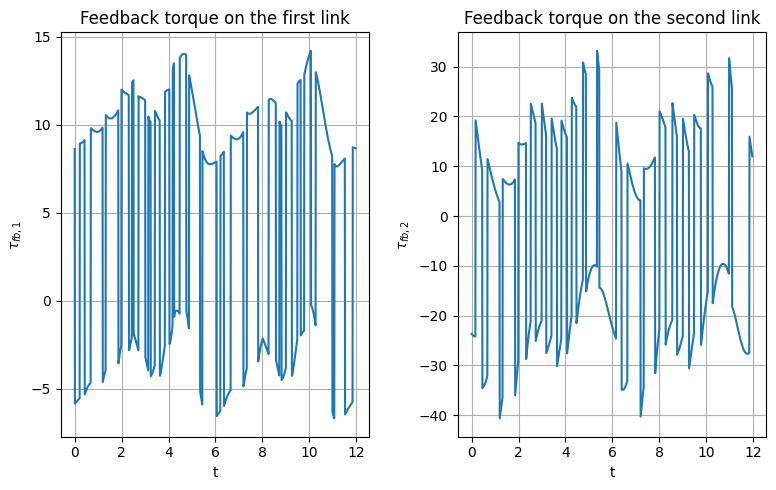

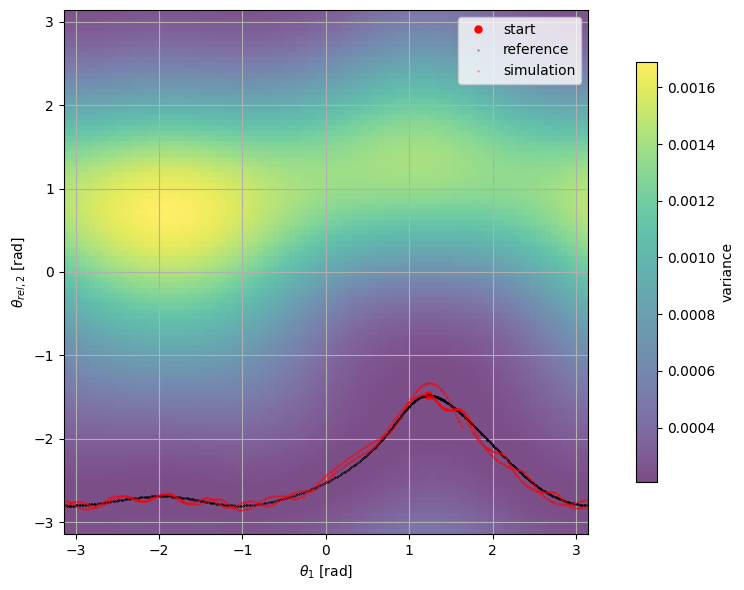

In [14]:
# Now we added two contributions: the variance-repelling term as in task 3f and a damping term that slows down the movement (the higher
# the speed, the higher the torque reduction). We can clearly see the effect of all three contributions by playing with the gains.
# Kp multiplies both the prediction (mean) of the GP and the variance-repelling term (for how the control law is defined in the notebook), 
# making the robot faster but also more oscillatory around the low-variance area (which is the reference path). K_var has the same role as 
# in the previous task, and also in this case is the key to "force" the robot to stay within configurations where the GP can make reasonable
# predictions (that's why now the performance has improved a lot). Finally, Kd gain helps avoiding excessive torques that would make the 
# already fast robot accelerate even more. This contribution is also very important, as it helps containing the speeds if the links are
# moving too fast (the GP alone is not able to do this, as it doesn't know anything about the current speed).
# In the plots below, similarly to the previous notebook, we can see how the input torques are still discontinuous, due to the sign operator
# in the control law. Again, from the second plot, the variance-repelling term helps maintaining the configurations within areas where the 
# predictions make sense.


##### CODE FOR THE PLOTS #####
if not AUTOGRADING:
    plt.close('FIGURE 1')
    plt.close('FIGURE 2')
    
    # Uncertainty
    theta_1_range = np.linspace(-np.pi, np.pi, 100)
    theta_2_range = np.linspace(-np.pi, np.pi, 100)
    theta_1_grid, theta_2_grid = np.meshgrid(theta_1_range, theta_2_range)
    input_points = np.column_stack((theta_1_grid.flatten(), theta_2_grid.flatten()))
    X_test = torch.tensor(input_points, dtype=torch.float32)
    
    with torch.no_grad():
        var = controller_model.predict(X_test).variance
        var1 = var[:, 0].view(100, 100).detach().cpu().numpy()
        var2 = var[:, 1].view(100, 100).detach().cpu().numpy()
        var_med = (var1 + var2)/2
    
    # Plot torques
    fig, axs = plt.subplots(1, 2, figsize=(8, 5), num='FIGURE 1')
    
    axs[0].plot(sim_ts['t_ts'], sim_ts['tau_fb_ts'][:,0])
    axs[0].grid(True)
    axs[0].set_xlabel('t')
    axs[0].set_ylabel(r'$\tau_{fb,1}$')
    axs[0].set_title('Feedback torque on the first link')
    
    axs[1].plot(sim_ts['t_ts'], sim_ts['tau_fb_ts'][:,1])
    axs[1].grid(True)
    axs[1].set_xlabel('t')
    axs[1].set_ylabel(r'$\tau_{fb,2}$')
    axs[1].set_title('Feedback torque on the second link')
    
    plt.tight_layout()
    plt.show()
    
    # Plot uncertainty
    fig = plt.figure(figsize=(10, 6), num='FIGURE 2')
    
    th_ref1 = normalize_link_angles(traj_ts['th_ts'][:,0])
    th_ref2 = normalize_link_angles(traj_ts['th_ts'][:,1] - th_ref1)
    
    th_sim1 = normalize_link_angles(sim_ts['th_ts'][:,0])
    th_sim2 = normalize_link_angles(sim_ts['th_ts'][:,1] - th_sim1)
    plt.plot(th_ref1[0], th_ref2[0], color='r', linestyle='', marker='o', markersize=5, label='start')
    plt.plot(th_ref1, th_ref2, color='k', linestyle='', marker='.', markersize=0.5, label='reference')
    plt.plot(th_sim1, th_sim2, color='r', linestyle='', marker='.', markersize=0.5, label='simulation')
    im = plt.imshow(var_med, cmap='viridis', origin='lower', extent=[-np.pi, np.pi, -np.pi, np.pi], alpha=0.7)
    plt.grid(True)
    plt.xlabel(r'$\theta_1$ [rad]')
    plt.ylabel(r'$\theta_{rel,2}$ [rad]')
    fig.colorbar(im, label='variance', shrink=0.8)
    plt.legend()
    
    plt.tight_layout()
    plt.show()